# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [35]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [36]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    _,Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [37]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [38]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [39]:
IPython.display.Audio('aeiou.wav')

In [40]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [41]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

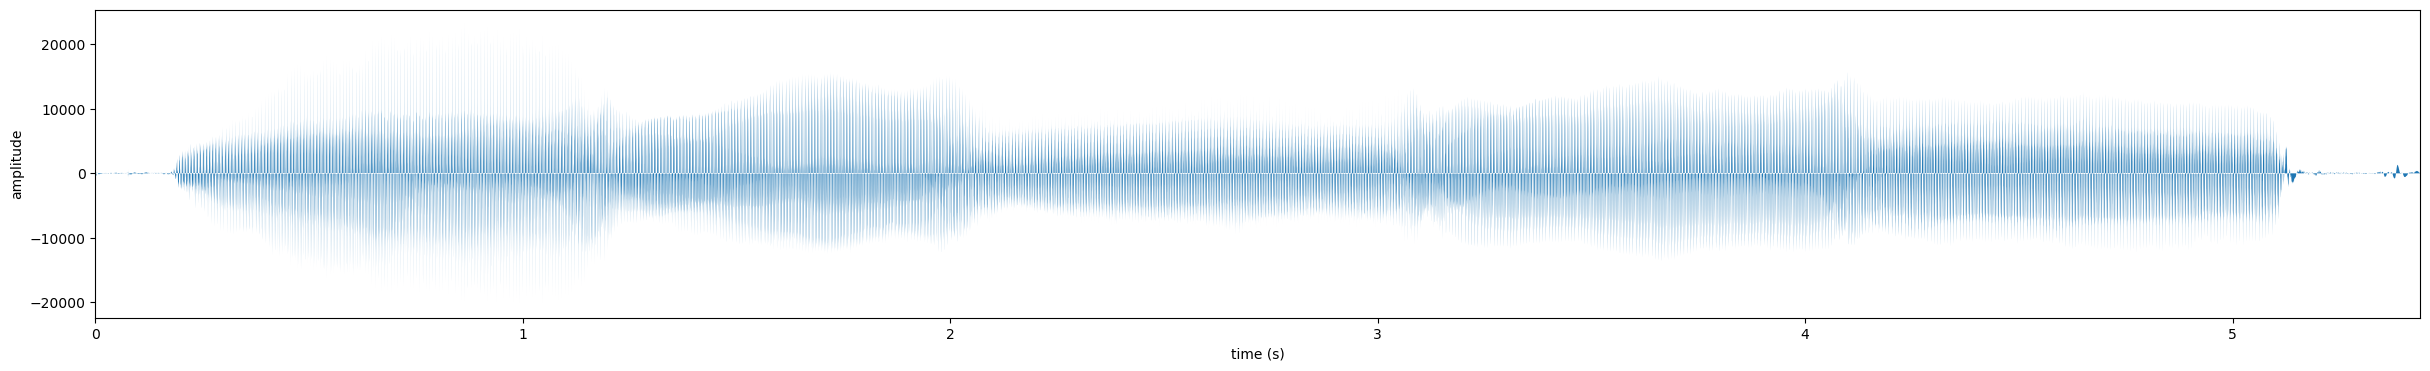

In [42]:
plot_sound(x, times)

In [43]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

---
---

# 1. Extraction of analysis marks


In [44]:
def analysisPittchMarks(x,Fs):
    """ Function that computes the analysis marks of a speech signal x """

    tas, Pas, voiceds = [0], [0.01*Fs], [0]
    count = 0
    while (len(x) > tas[-1]+2.5*Pas[-1]):
        s = x[int(tas[-1]):int(tas[-1]+2.5*Pas[-1])]
        P, voiced = period(s,Fs)
        Pas.append(P)
        tas.append(tas[-1]+Pas[-1])
        voiceds.append(voiced)
    A = np.vstack([tas,voiceds,Pas])
    return A

In [45]:
A = analysisPittchMarks(x,Fs)
A.shape

(3, 706)

---

# 2. Synthesis and modification of the temporal and spectral scales

In [46]:
B = np.zeros((2,len(A[0,:])),dtype=int)
B[0,:] = A[0,:]
B[1,:] = np.arange(len(A[0,:]))

### 2.1 Signal synthesis

In [47]:
from scipy import signal

def synthesis(x,Fs,A,B):
    """ Function that synthesizes a speech signal x from its pitch marks"""

    Ns, ts = B[1,:].astype(int), B[0,:]
    tas_bis, Pas_bis = A[0,Ns], A[2,Ns]
    t, P = ts[-1],Pas_bis[-1]
    n = int(t + P)

    # Initialize the output signal
    out = np.zeros(n)
    for i in range(1,len(ts)):
        t, t_s = tas_bis[i], ts[i]
        P = Pas_bis[i]
        s = x[int(t - P):int(t + P)]
        window = signal.windows.hann(len(s))
        x0 = s*window
        n1, n2 = len(out[int(t_s - P):int(t_s + P)]),len(x0)
        # Overlap and add
        if n1 == n2: out[int(t_s - P):int(t_s + P)] += x0
    return out

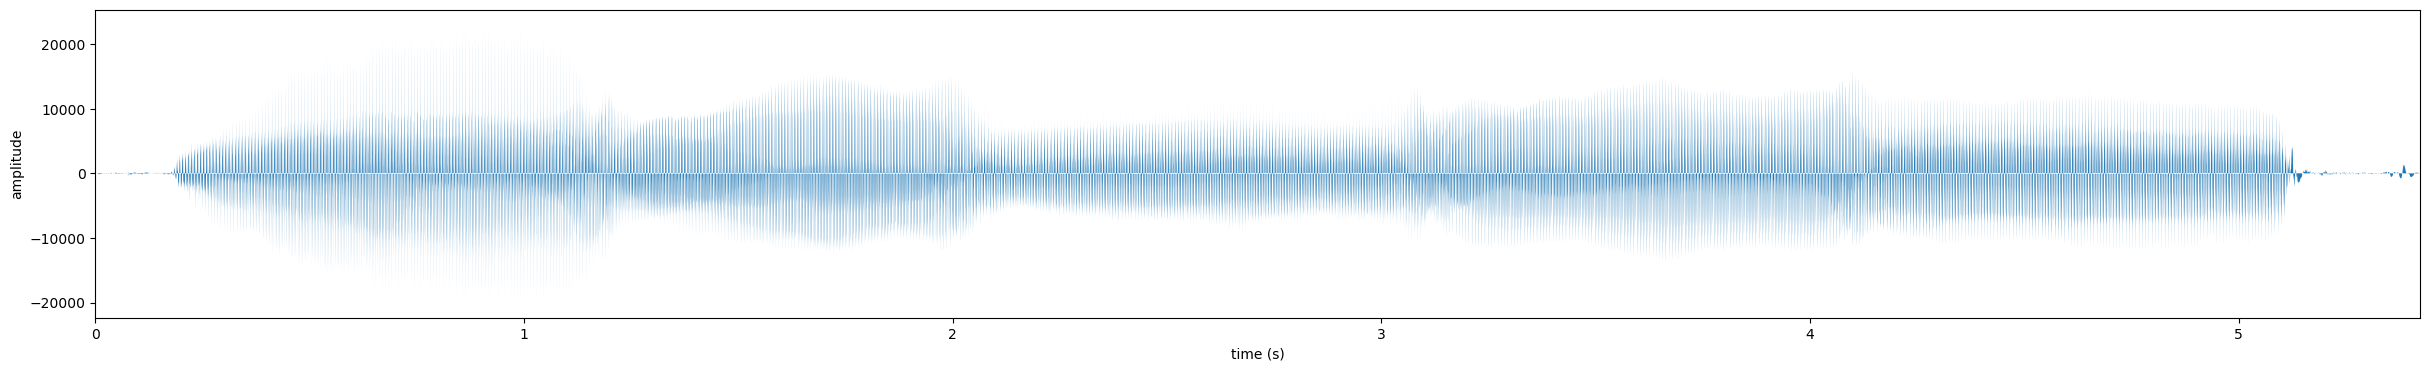


 Longueur de x: 59964 
 Longueur de y: 59800


In [48]:
y = synthesis(x,Fs,A,B)

# Plot the original and the synthesized signals
timestep = 1/float(Fs)
times_y = np.arange(len(y))*timestep
plot_sound(y,times_y)
print('\n',"Longueur de x:",len(x),'\n',"Longueur de y:",len(y))

In [49]:
filename = 'y.wav'

write(filename, Fs, np.array(y, dtype=np.int16))
sound_y = os.path.join(data_path, filename)
wavefile = load_sound(sound_y)
print(wavefile.getparams())
IPython.display.Audio(filename,)

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59800, comptype='NONE', compname='not compressed')


### 2.2 Modification of temporal scale 

In [50]:
def ChangeTimeScale(alpha,A,Fs):
    t,n=[A[0,0]],[0,1]
    while int(n[-1])<np.shape(A)[1]:
        t.append(t[-1]+ A[2,int(n[-1])])
        n.append(n[-1]+1/alpha)
    print(len(n),len(t))
    B = np.array([t,n[:-1]]).astype(int)
    print("b:",np.shape(B))
    return B

We extend and compress the time

1201 1200
b: (2, 1200)


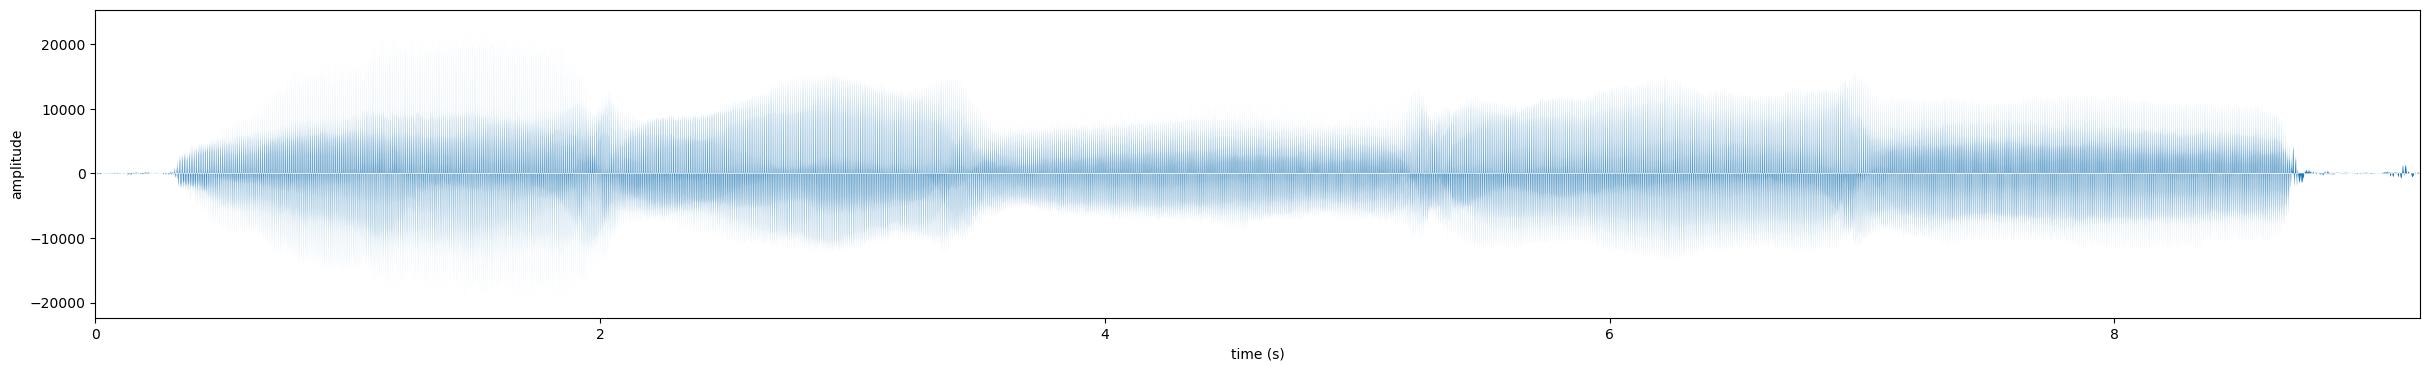

In [51]:
alpha = 1.7

B = ChangeTimeScale(alpha,A,Fs)
y2 = synthesis(x, Fs, A, B)

times = np.arange(len(y2))*timestep
plot_sound(y2, times)



filename = 'y2.wav'

write(filename, Fs, np.array(y2, dtype=np.int16))
sound_y = os.path.join(data_path, filename)
wavefile = load_sound(sound_y)
IPython.display.Audio(filename)

496 495
b: (2, 495)


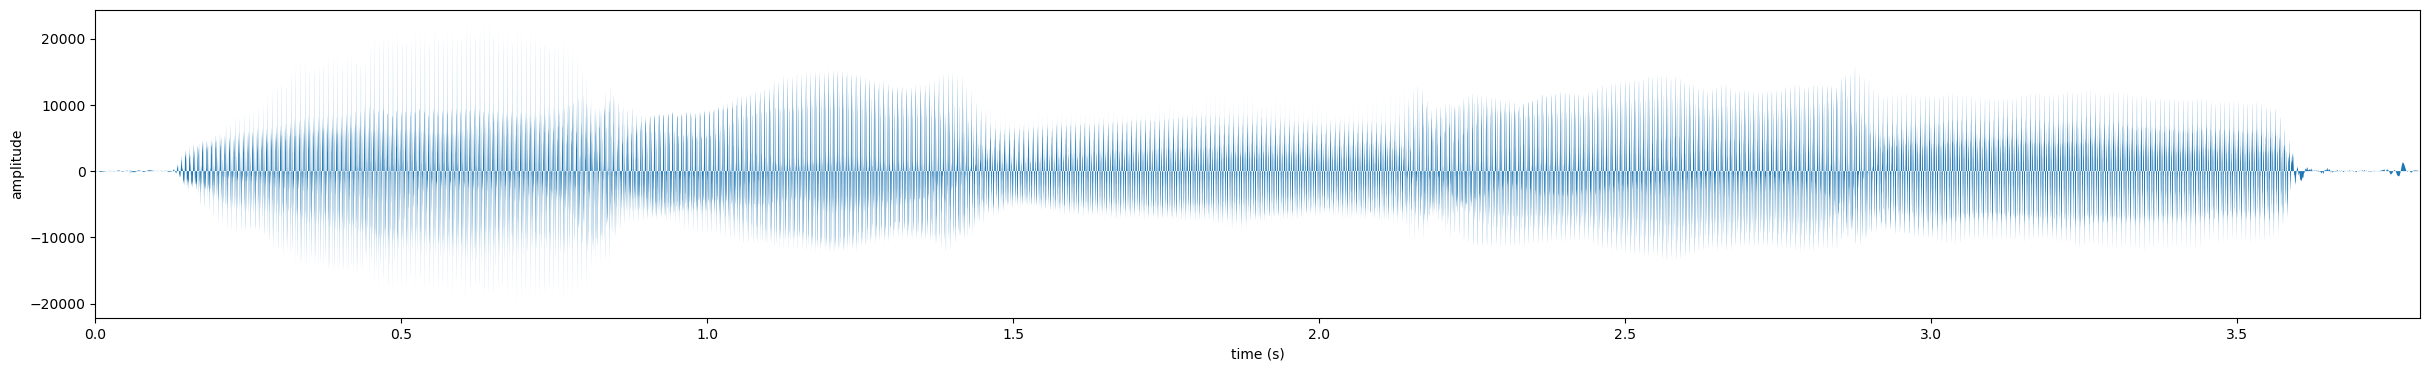

In [52]:
alpha = 0.7

B = ChangeTimeScale(alpha,A,Fs)
y2 = synthesis(x, Fs, A, B)

times = np.arange(len(y2))*timestep
plot_sound(y2, times)



filename = 'y2.wav'

write(filename, Fs, np.array(y2, dtype=np.int16))
sound_y = os.path.join(data_path, filename)
wavefile = load_sound(sound_y)
IPython.display.Audio(filename)

### 2.3 Modification of the spectral scale

In [53]:
def ChangePitchScale(beta,A,Fs):
    scale = np.ones(len(A[1,:]))/beta
    scale[A[1,:]==0]=1
    ts,n=[A[0,0]],[0,1]
    i=0
    while int(n[-1])<np.shape(A)[1]:
        n0 = int(n[-1])
        ts.append(int(ts[-1]+ scale[n0]*A[2,n0]))
        n.append(n[-1]+scale[n0])
        i+=1
    B = np.array([ts,n[:-1]],dtype=int)
    return B

Higher frequency

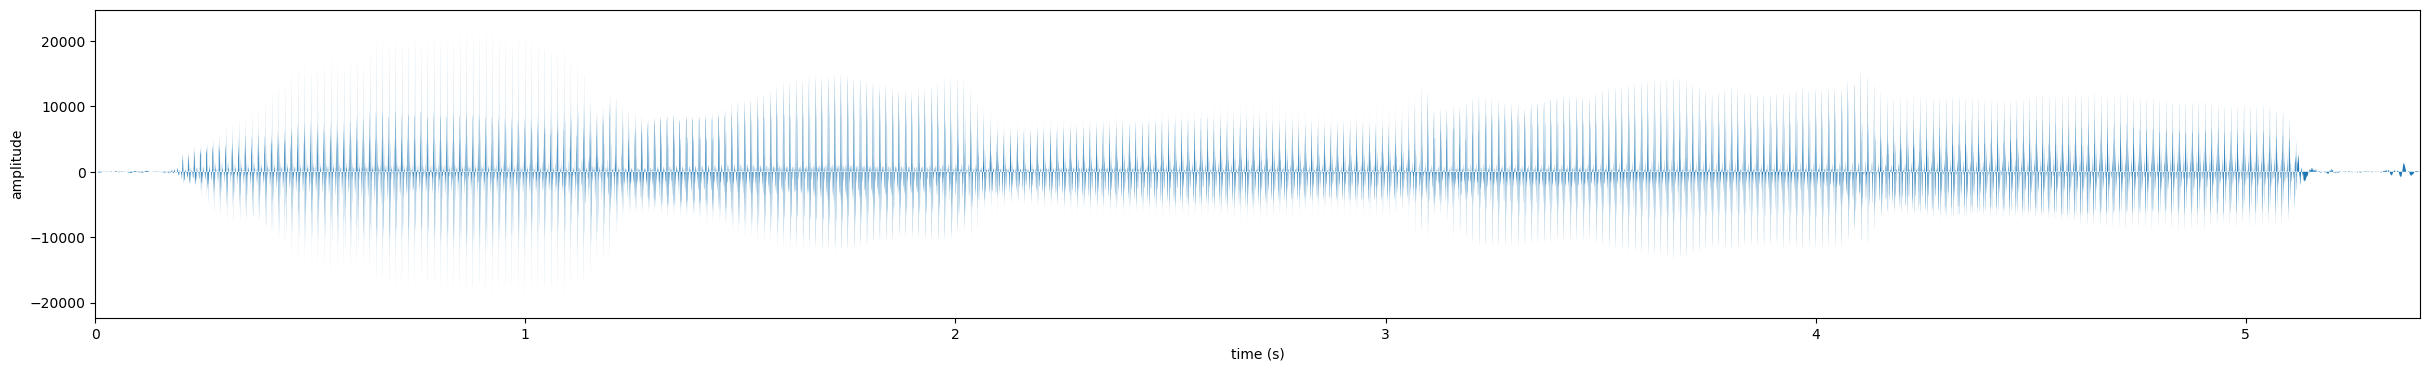

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59600, comptype='NONE', compname='not compressed')
lenght of y3:  59600
lenght of s:  59964


In [54]:
beta = 0.5
B = ChangePitchScale(beta,A,Fs)
y3 = synthesis(x, Fs, A, B)

times = np.arange(len(y3))*timestep
plot_sound(y3, times)

filename = 'y3.wav'

write(filename, Fs, np.array(y3, dtype=np.int16))
sound_y = os.path.join(data_path, filename)
wavefile = load_sound(sound_y)
print(wavefile.getparams())
print('lenght of y3: ',len(y3))
print('lenght of s: ',len(x))
IPython.display.Audio(filename)

Lower frequency

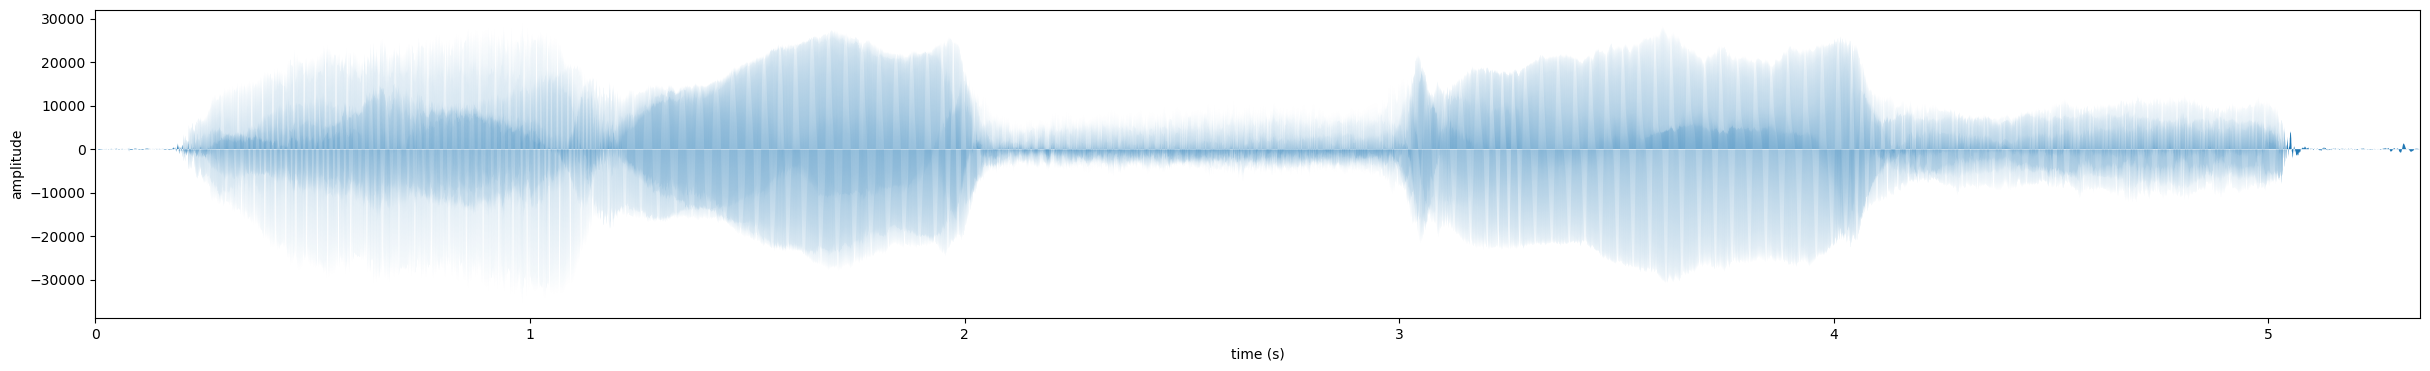

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=58977, comptype='NONE', compname='not compressed')
lenght of y3:  58977
lenght of s:  59964


In [55]:
beta = 3
B = ChangePitchScale(beta,A,Fs)
y3 = synthesis(x, Fs, A, B)

times = np.arange(len(y3))*timestep
plot_sound(y3, times)

filename = 'y3.wav'

write(filename, Fs, np.array(y3, dtype=np.int16))
sound_y = os.path.join(data_path, filename)
wavefile = load_sound(sound_y)
print(wavefile.getparams())
print('lenght of y3: ',len(y3))
print('lenght of s: ',len(x))
IPython.display.Audio(filename)

### 2.4 Joint modification of the temporal and spectral scales

In [56]:
def ChangeBothScales(alpha,beta,A,Fs):
    """ Function that changes both the time and pitch scales of a speech signal x """
    scale = np.ones(len(A[1,:]))/beta
    scale[A[1,:]==0]=1
    ts,n=[A[0,0]],[0,1]
    i=0
    while int(n[-1])<np.shape(A)[1]:
        n0 = int(n[-1])
        ts.append(int(ts[-1]+ scale[n0]*A[2,n0]))
        n.append(n[-1]+scale[n0]/alpha)
        i+=1
    B = np.array([ts,n[:-1]],dtype=int)
    return B

In [57]:
B  = ChangeBothScales(alpha,beta,A,Fs)
y22 = synthesis(x,Fs,A,B)
print(np.shape(y22))

(41482,)


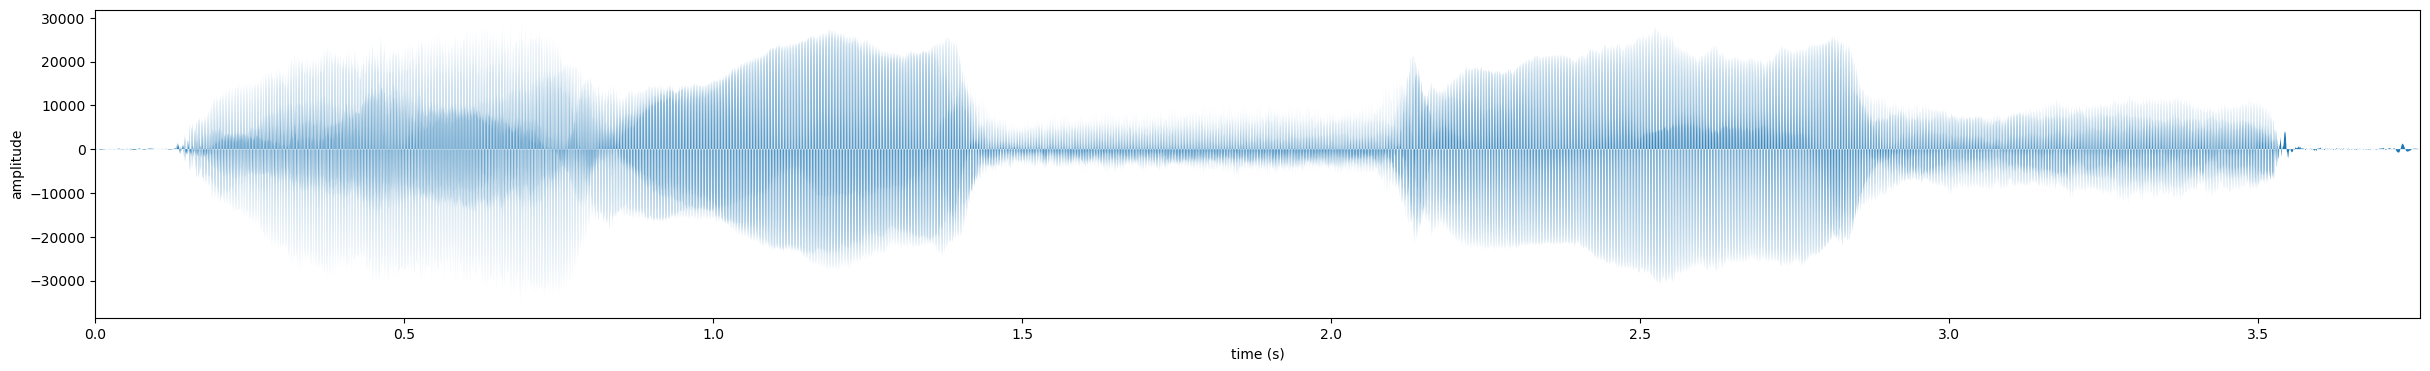

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=41482, comptype='NONE', compname='not compressed')


In [58]:
alpha = 1.5
beta = 0.5

filename = 'y22.wav'

times= np.arange(len(y22))*timestep
plot_sound(y22,times)

write(filename, Fs, np.array(y22, dtype=np.int16))
sound_y = os.path.join(data_path, filename)
wavefile = load_sound(sound_y)
print(wavefile.getparams())
IPython.display.Audio(filename,)